# Rolling Statistics in Finance (MSFT Example)

This notebook demonstrates that annualised return and risk change over time (regime-like behavior), and shows how moving averages smooth prices.

## Setup

We use only `pandas`, `numpy`, and `matplotlib` (no seaborn).

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility for synthetic fallback data.
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.options.display.float_format = '{:,.6f}'.format

## 1) Load Data (CSV Preferred, Synthetic Fallback)

The notebook first tries `MSFT.csv` in the working directory. For robustness it also checks `msft.csv`.
If no suitable file is found, it generates a realistic synthetic geometric random walk so the notebook still runs end-to-end.

In [3]:
def load_or_simulate_prices():
    csv_candidates = [Path('MSFT.csv'), Path('msft.csv')]

    for csv_path in csv_candidates:
        if not csv_path.exists():
            continue

        raw = pd.read_csv(csv_path)

        # Find Date column case-insensitively.
        date_col = next((col for col in raw.columns if col.strip().lower() == 'date'), None)
        if date_col is None:
            continue

        # Accept common price columns case-insensitively.
        lower_map = {col.strip().lower(): col for col in raw.columns}
        price_col = None
        for candidate in ['adj close', 'close', 'msft']:
            if candidate in lower_map:
                price_col = lower_map[candidate]
                break

        if price_col is None:
            continue

        df_local = raw[[date_col, price_col]].copy()
        df_local = df_local.rename(columns={date_col: 'Date', price_col: 'Close'})
        df_local['Date'] = pd.to_datetime(df_local['Date'], errors='coerce')
        df_local['Close'] = pd.to_numeric(df_local['Close'], errors='coerce')
        df_local = df_local.dropna(subset=['Date', 'Close']).sort_values('Date').set_index('Date')

        if not df_local.empty:
            return df_local, f'csv:{csv_path.name}'

    # Synthetic fallback (~7 years, business days) with regime-like behavior.
    dates = pd.bdate_range(start='2014-01-01', end='2021-12-31')
    n = len(dates)

    rng = np.random.default_rng(RANDOM_SEED)

    # Piecewise drift/volatility to create regime changes.
    mu = np.full(n, 0.00030)
    sigma = np.full(n, 0.010)

    mu[n // 3: 2 * n // 3] = 0.00010
    sigma[n // 3: 2 * n // 3] = 0.018

    mu[2 * n // 3:] = 0.00040
    sigma[2 * n // 3:] = 0.012

    synthetic_log_ret = mu + sigma * rng.standard_normal(n)
    synthetic_close = 100.0 * np.exp(np.cumsum(synthetic_log_ret))

    df_synth = pd.DataFrame({'Close': synthetic_close}, index=dates)
    return df_synth, 'synthetic_gbm'


df, data_source = load_or_simulate_prices()
print(f'Data source: {data_source}')

Data source: csv:MSFT.csv


## 2) Compute Log Returns

We use log returns because they add naturally over time and are standard in many risk/return models:

`log_ret_t = ln(P_t / P_{t-1})`

In [4]:
df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
df = df.dropna(subset=['log_ret']).copy()

## 3) Full-Period Annualised Return and Risk

- Annualised mean log return = `mean(log_ret) * 252`
- Annualised volatility = `std(log_ret) * sqrt(252)`

In [5]:
full_ann_mean = df['log_ret'].mean() * 252
full_ann_vol = df['log_ret'].std() * np.sqrt(252)

print('Full-period metrics:')
print(f'  Annualised mean log return: {full_ann_mean:.6f}')
print(f'  Annualised volatility:      {full_ann_vol:.6f}')

Full-period metrics:
  Annualised mean log return: 0.274103
  Annualised volatility:      0.273562


## 4) Rolling Annualised Return (252-day window)

We compute rolling annualised return two equivalent ways:
- A) rolling sum of daily log returns over 252 days
- B) rolling mean of daily log returns times 252

These should be nearly identical.

Max absolute difference between method A and B: 0.000000000000


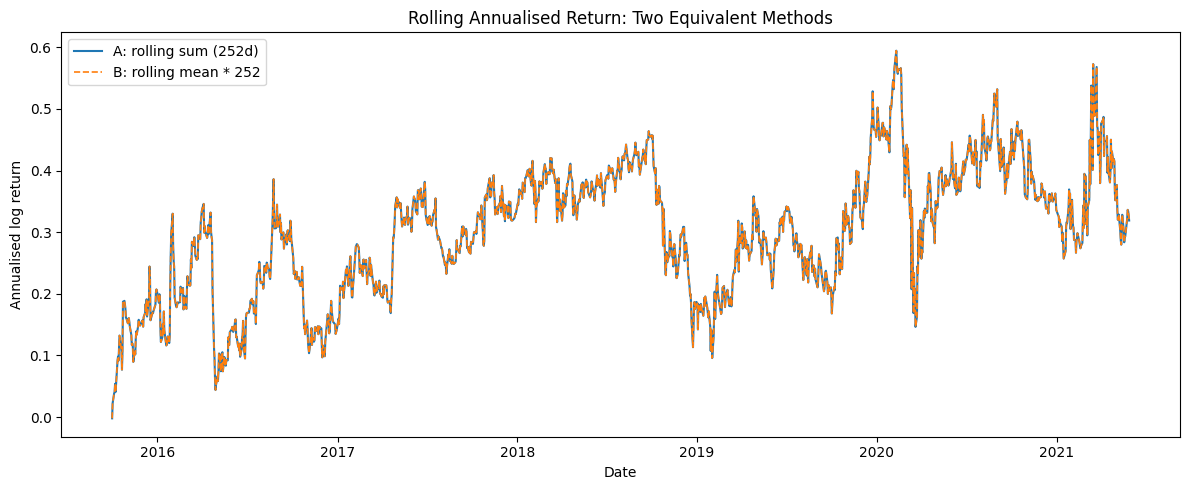

In [6]:
window = 252

roll_ret_sum = df['log_ret'].rolling(window).sum()
roll_ret_mean = df['log_ret'].rolling(window).mean() * 252

max_abs_diff = (roll_ret_sum - roll_ret_mean).abs().max()
print(f'Max absolute difference between method A and B: {max_abs_diff:.12f}')

plt.figure(figsize=(12, 5))
plt.plot(roll_ret_sum.index, roll_ret_sum.values, label='A: rolling sum (252d)', linewidth=1.5)
plt.plot(roll_ret_mean.index, roll_ret_mean.values, label='B: rolling mean * 252', linewidth=1.2, linestyle='--')
plt.title('Rolling Annualised Return: Two Equivalent Methods')
plt.xlabel('Date')
plt.ylabel('Annualised log return')
plt.legend()
plt.tight_layout()
plt.show()

Because a 252-day window needs 252 observations, the first `window - 1` entries are `NaN` by construction.

## 5) Rolling Annualised Volatility

In [7]:
roll_vol = df['log_ret'].rolling(window).std() * np.sqrt(252)

## 6) Rolling Annualised Return Plot

The horizontal line is the full-period annualised mean return for comparison.

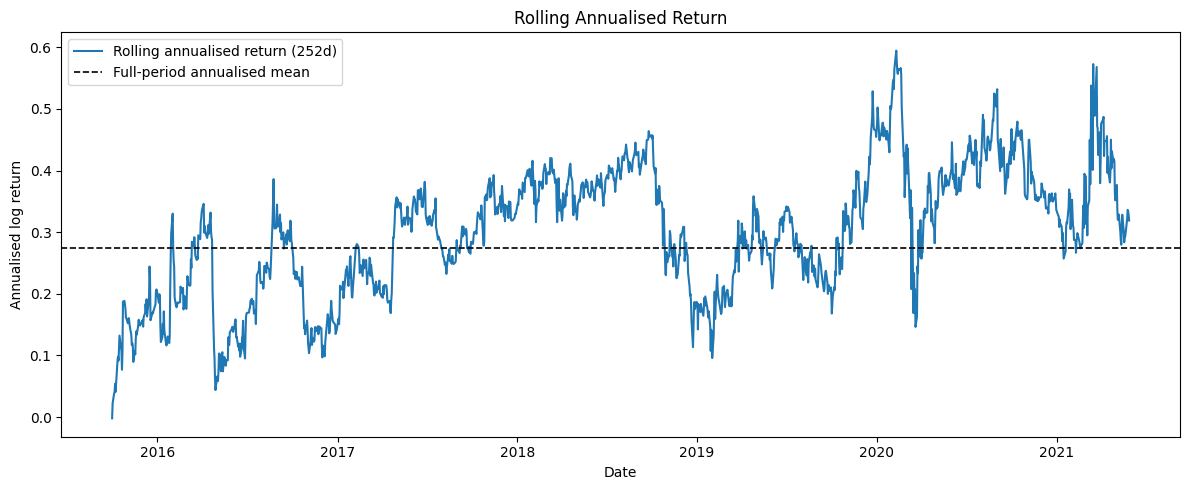

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(roll_ret_sum.index, roll_ret_sum.values, label='Rolling annualised return (252d)', linewidth=1.5)
plt.axhline(full_ann_mean, color='black', linestyle='--', linewidth=1.2, label='Full-period annualised mean')
plt.title('Rolling Annualised Return')
plt.xlabel('Date')
plt.ylabel('Annualised log return')
plt.legend()
plt.tight_layout()
plt.show()

## 7) Rolling Annualised Volatility Plot

The horizontal line is the full-period annualised volatility for comparison.

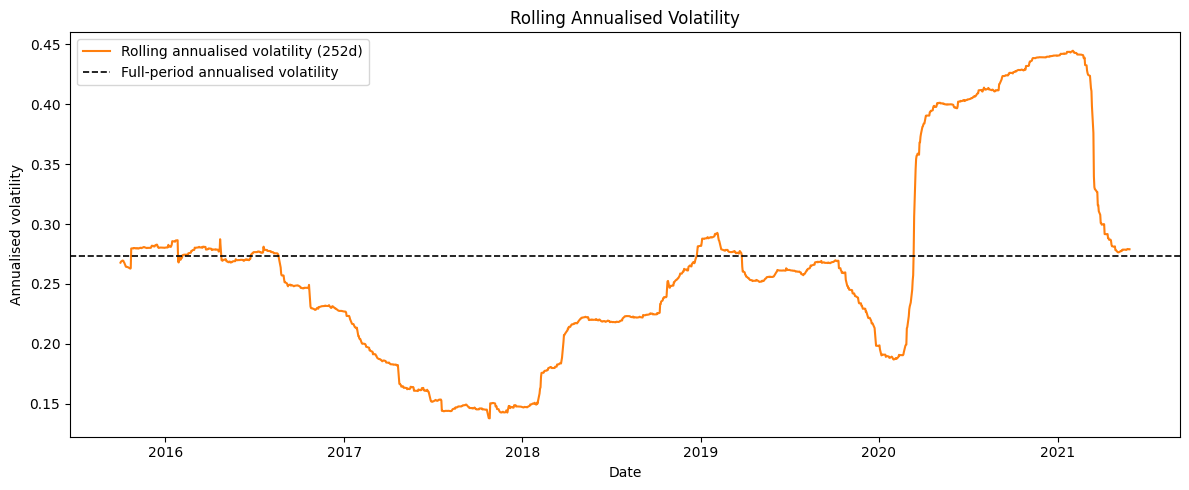

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(roll_vol.index, roll_vol.values, color='tab:orange', label='Rolling annualised volatility (252d)', linewidth=1.5)
plt.axhline(full_ann_vol, color='black', linestyle='--', linewidth=1.2, label='Full-period annualised volatility')
plt.title('Rolling Annualised Volatility')
plt.xlabel('Date')
plt.ylabel('Annualised volatility')
plt.legend()
plt.tight_layout()
plt.show()

## 8) Return and Risk on One Figure (Two Y-Axes)

Left axis: rolling annualised return. Right axis: rolling annualised volatility.

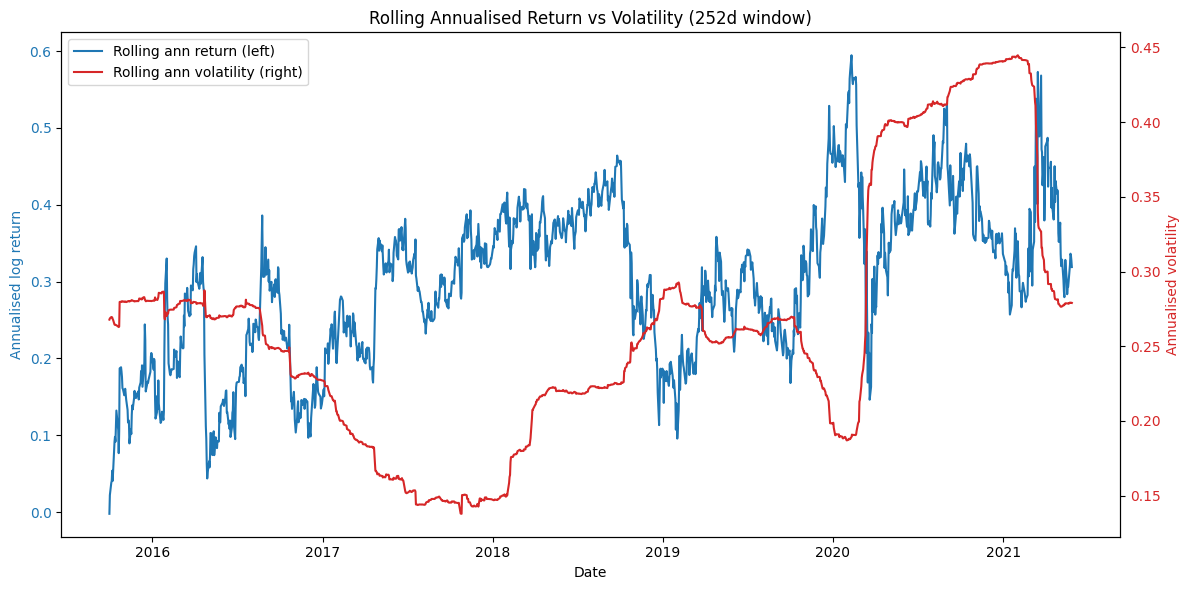

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))

line1 = ax1.plot(roll_ret_sum.index, roll_ret_sum.values, color='tab:blue', linewidth=1.5, label='Rolling ann return (left)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Annualised log return', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
line2 = ax2.plot(roll_vol.index, roll_vol.values, color='tab:red', linewidth=1.5, label='Rolling ann volatility (right)')
ax2.set_ylabel('Annualised volatility', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Rolling Annualised Return vs Volatility (252d window)')
fig.tight_layout()
plt.show()

## Interpretation

- Return and risk are not constant through time; rolling estimates move as market regimes change.
- Different sample periods can produce very different conclusions about performance and risk.
- Window choice is a trade-off: shorter windows react quickly but are noisy; longer windows are smoother but slower to reflect new conditions.

## 9) Moving Average Smoothing on Price

A simple moving average (SMA) smooths short-term fluctuations and can highlight trend direction.

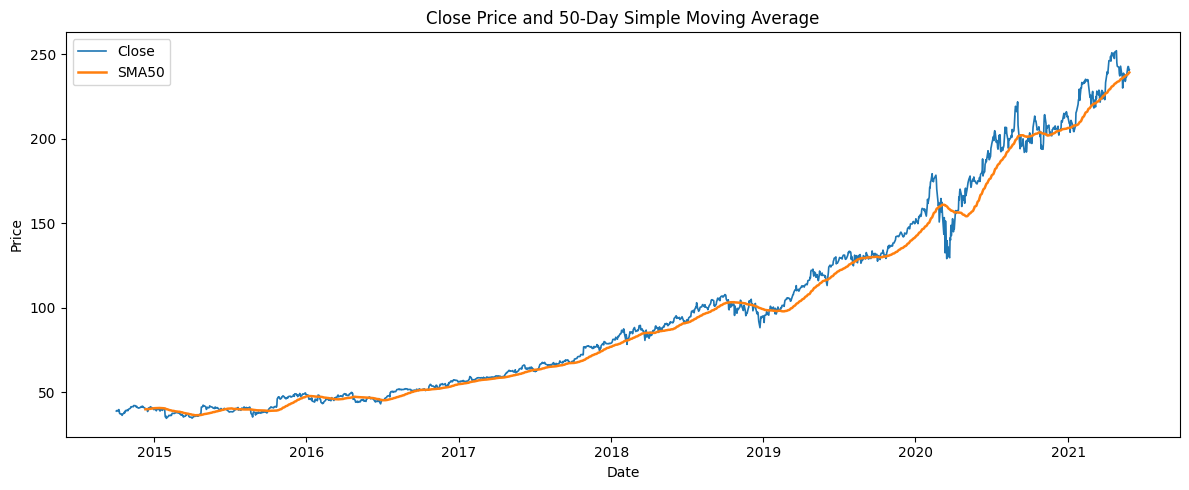

In [11]:
sma_window = 50
df['SMA50'] = df['Close'].rolling(sma_window).mean()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Close'], label='Close', linewidth=1.2)
plt.plot(df.index, df['SMA50'], label='SMA50', linewidth=1.8, color='tab:orange')
plt.title('Close Price and 50-Day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

Smoothing helps visualize trend-following intuition, but it does not remove underlying market risk; it only filters high-frequency noise.

## 10) Final Dataset Check

In [12]:
print(f'Data source: {data_source}')
print(f'Date range: {df.index.min().date()} to {df.index.max().date()}')
print(f'Number of rows: {len(df)}')

print('\nHead:')
print(df.head())

print('\nTail:')
print(df.tail())

Data source: csv:MSFT.csv
Date range: 2014-10-02 to 2021-05-28
Number of rows: 1676

Head:
               Close   log_ret  SMA50
Date                                 
2014-10-02 38.761574 -0.003055    NaN
2014-10-03 39.041103  0.007186    NaN
2014-10-06 39.041103  0.000000    NaN
2014-10-07 38.566746 -0.012225    NaN
2014-10-08 39.625584  0.027085    NaN

Tail:
                Close   log_ret      SMA50
Date                                      
2021-05-24 241.744522  0.022624 237.869670
2021-05-25 242.650650  0.003741 238.206114
2021-05-26 242.428955 -0.000914 238.482343
2021-05-27 240.327469 -0.008706 238.729429
2021-05-28 240.684143  0.001483 239.105213
